# MNIST for Fashion

# Initialize

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
sns.set_theme()

%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("data/fashion-mnist_train.csv")
test = pd.read_csv("data/fashion-mnist_test.csv")

In [3]:
# extract the labels and imgs arrays of the dataset
labels = train["label"].to_numpy()
imgs = train.loc[:, "pixel1":].to_numpy()

test_labels = train["label"].to_numpy()
test_imgs = train.loc[:, "pixel1":].to_numpy()

# EDA

In [4]:
# We have a balanced dataset of each of the ten label
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

The class label of each image are summarized by the following list.

In [5]:
names= ["T-shirt/top", "Trouser", "Pullover",
        "Dress", "Coat", "Sandal", "Shirt",
        "Sneaker", "Bag", "Ankle boot"]
name_to_idx = {name: idx for idx, name in enumerate(names)}

# Plot the First Instance of each Category

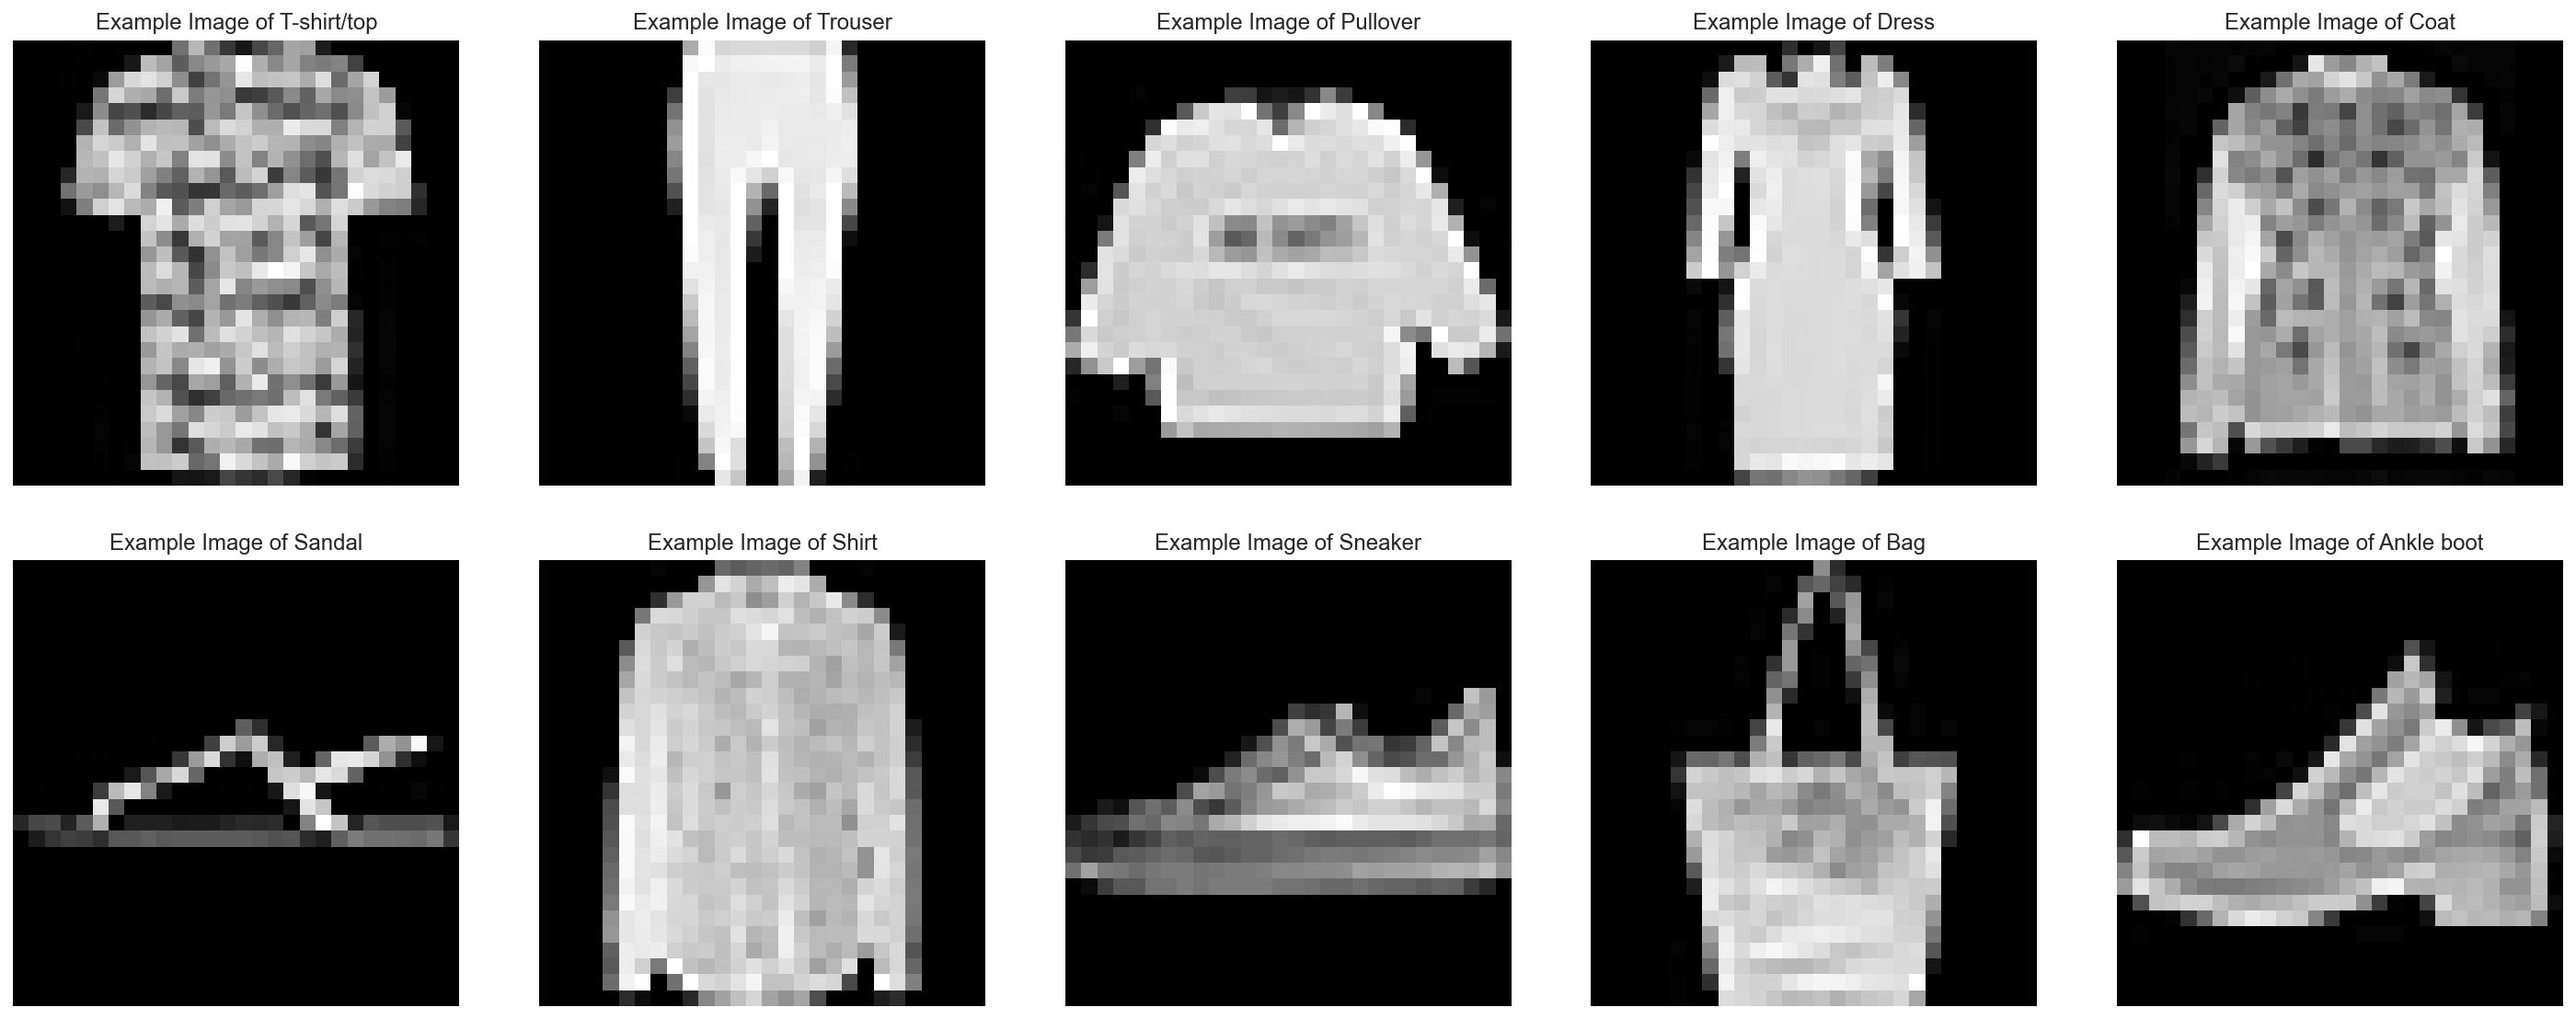

In [7]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
plt.tight_layout()
for label in range(10):
    for idx, l in enumerate(labels):
        if l == label:
            img = imgs[idx].reshape((28, -1))
            ax = axs[label//5, label%5]
            ax.set_title(f"Example Image of {names[label]}")
            ax.imshow(img, cmap='gray')
            ax.axis("off")
            break
plt.savefig("imgs/intro.png", dpi=200)

# Mean image of every thing

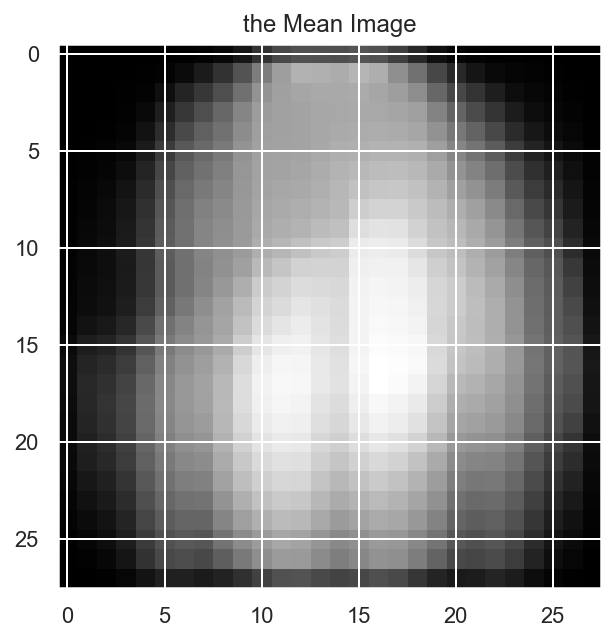

In [99]:
mean_img = np.mean(imgs, axis=0).reshape(-1, 28)
plt.figure(figsize=(5, 5))
plt.title(f"the Mean Image")
plt.imshow(mean_img, cmap='gray')

## Let's Calculate the mean Image of each Category

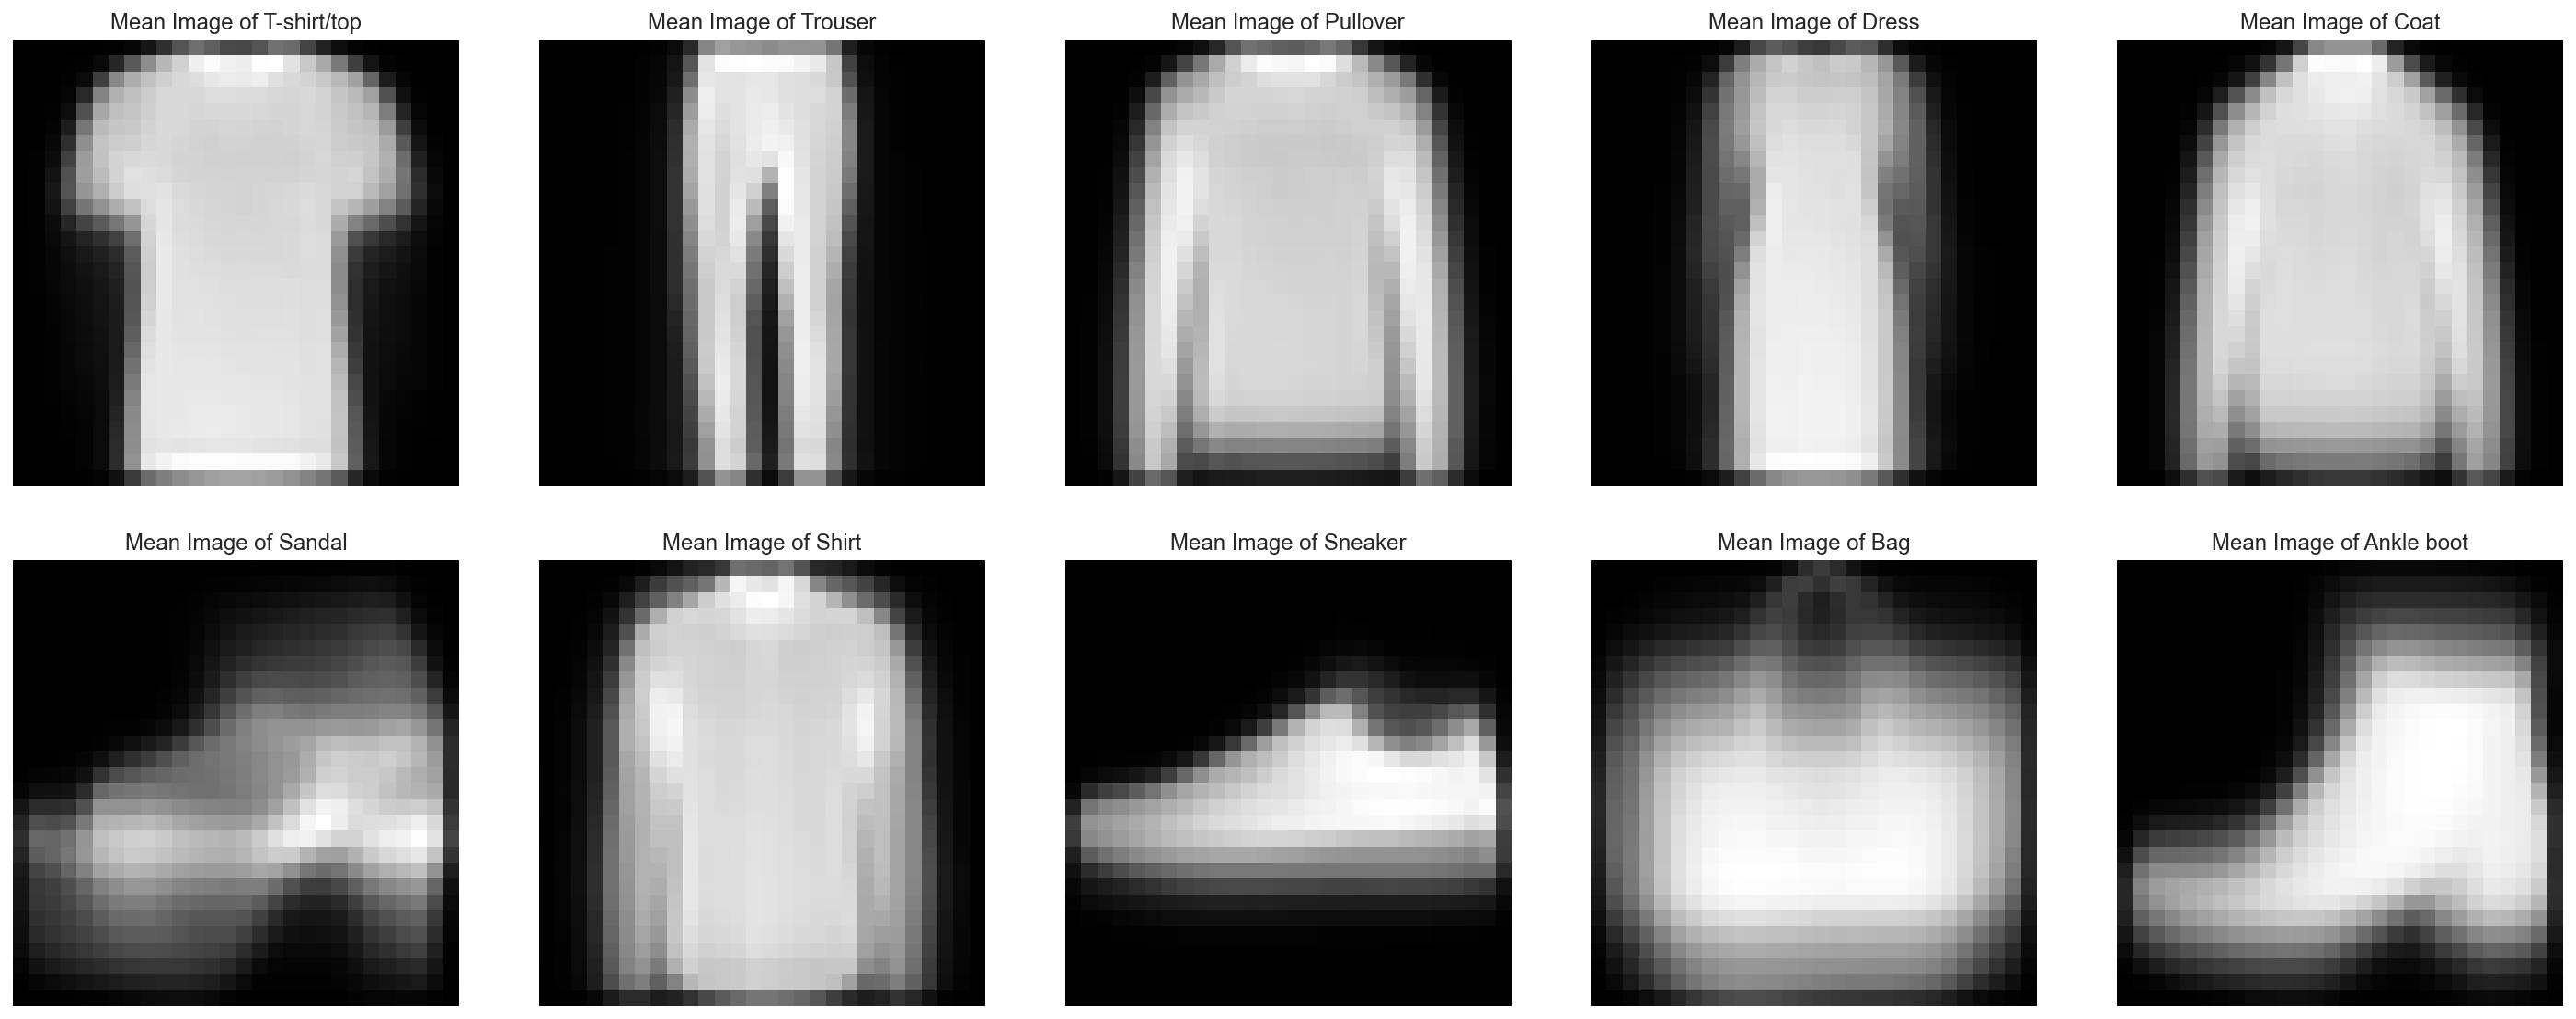

In [100]:
img_by_category = defaultdict(list)
for l, image in zip(labels, imgs):
    img_by_category[l].append(image)

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
plt.tight_layout()
for label in range(10):
    all_img = img_by_category[label]
    mean_img = np.mean(all_img, axis=0).reshape(-1, 28)
    ax = axs[label//5, label%5]
    ax.set_title(f"Mean Image of {names[label]}")
    ax.imshow(mean_img, cmap='gray')
    ax.axis("off")

From the mean images of each category, we can see that each category has distinct overall shape that the mean of each is dominant. Based on the overall looking of each category, we can further do the dimensionality reduction to map reduce the high dimensional image data into two dimension.

# PCA Dimensionality Reduction
PCA stands for principle component analysis, of which it finds the direction of the largest variance, and we can shrink our data size in storing all the image. This is also a lossy compression methods.

In [101]:
from sklearn.decomposition import PCA
pca = PCA()
transformed = pca.fit_transform(imgs)

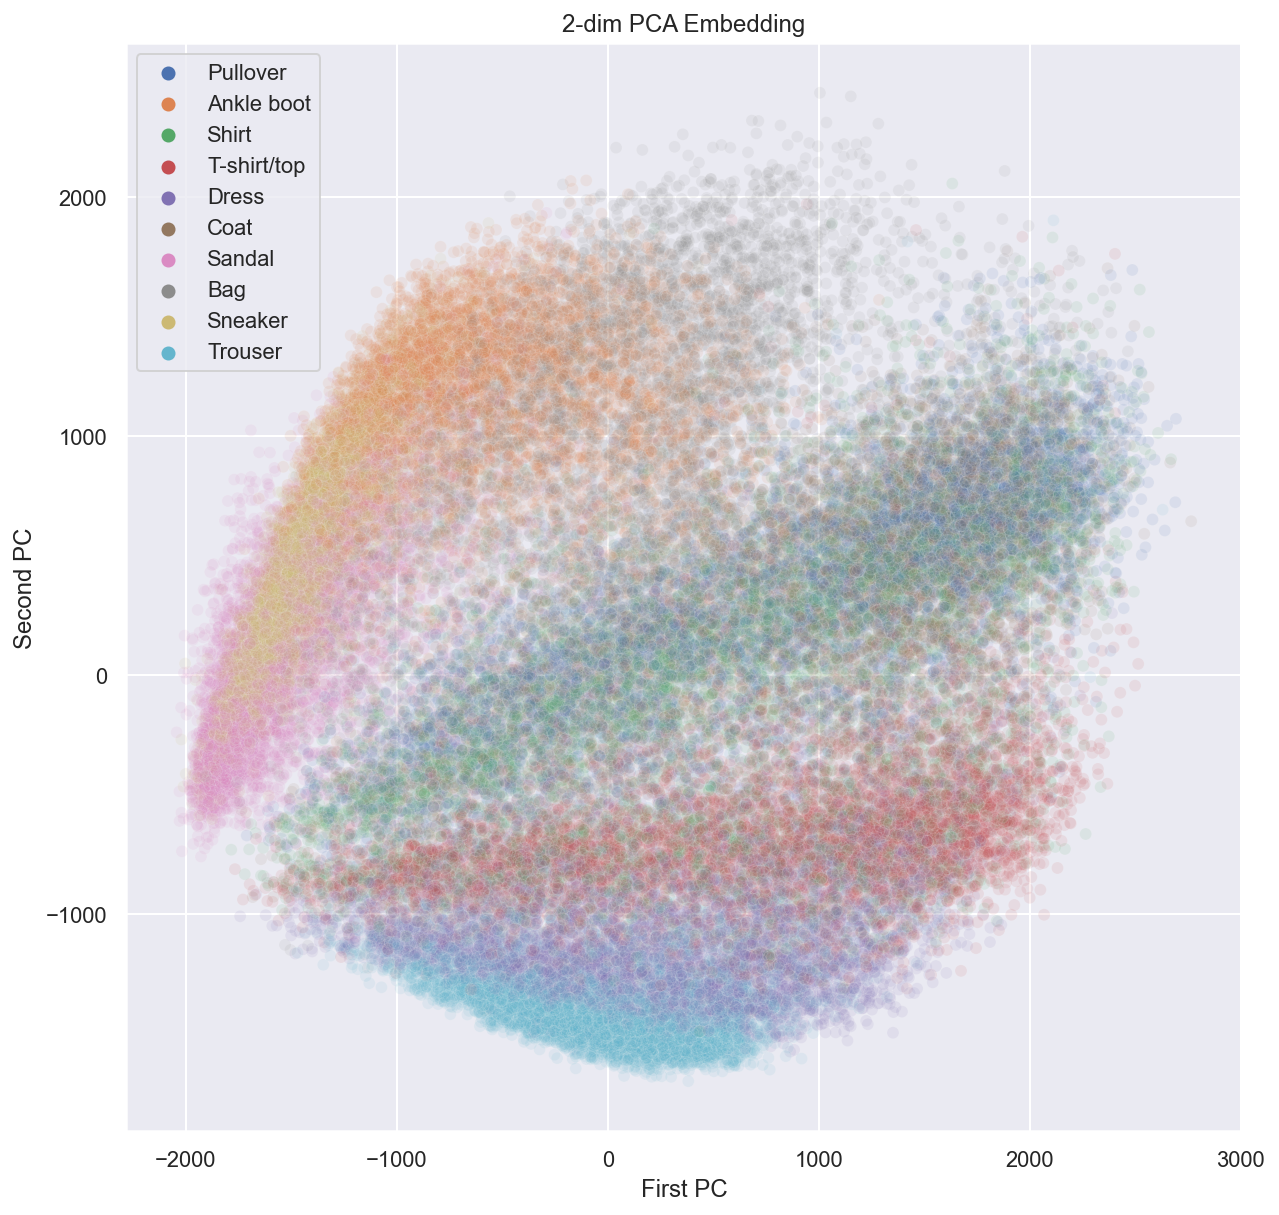

In [116]:
named_label = list(map(lambda x: names[x], labels))
plt.figure(figsize=(10,10))
two_pcs = transformed[:, :2]
sns.scatterplot(two_pcs[:, 0], two_pcs[:, 1], hue=named_label, alpha=0.1)
plt.xlabel("First PC")
plt.ylabel("Second PC")
plt.title("2-dim PCA Embedding")
plt.savefig("imgs/PCA.png", dpi=200)

From the graph we can see that there are clearly sub-structure of each cluster of data. Specifically, `Trouser` and `Dress` are pretty similar as they are mingled around the bottom of the transformed space. In addition, the `Sandal`, `Sneaker`, and `Ankle boot` are a mixture together, as they are all on the super category of shoes. Therefore, the euclidien distance in lower dimension space will represent the similarity between items.

However, only two principle components are not enought for us to clearly segregate the data.

In [103]:
# Find the proportion of variance explained with the first two PCs
sum(pca.explained_variance_ratio_[:2])

0.4673902181151144

# PCA plotting

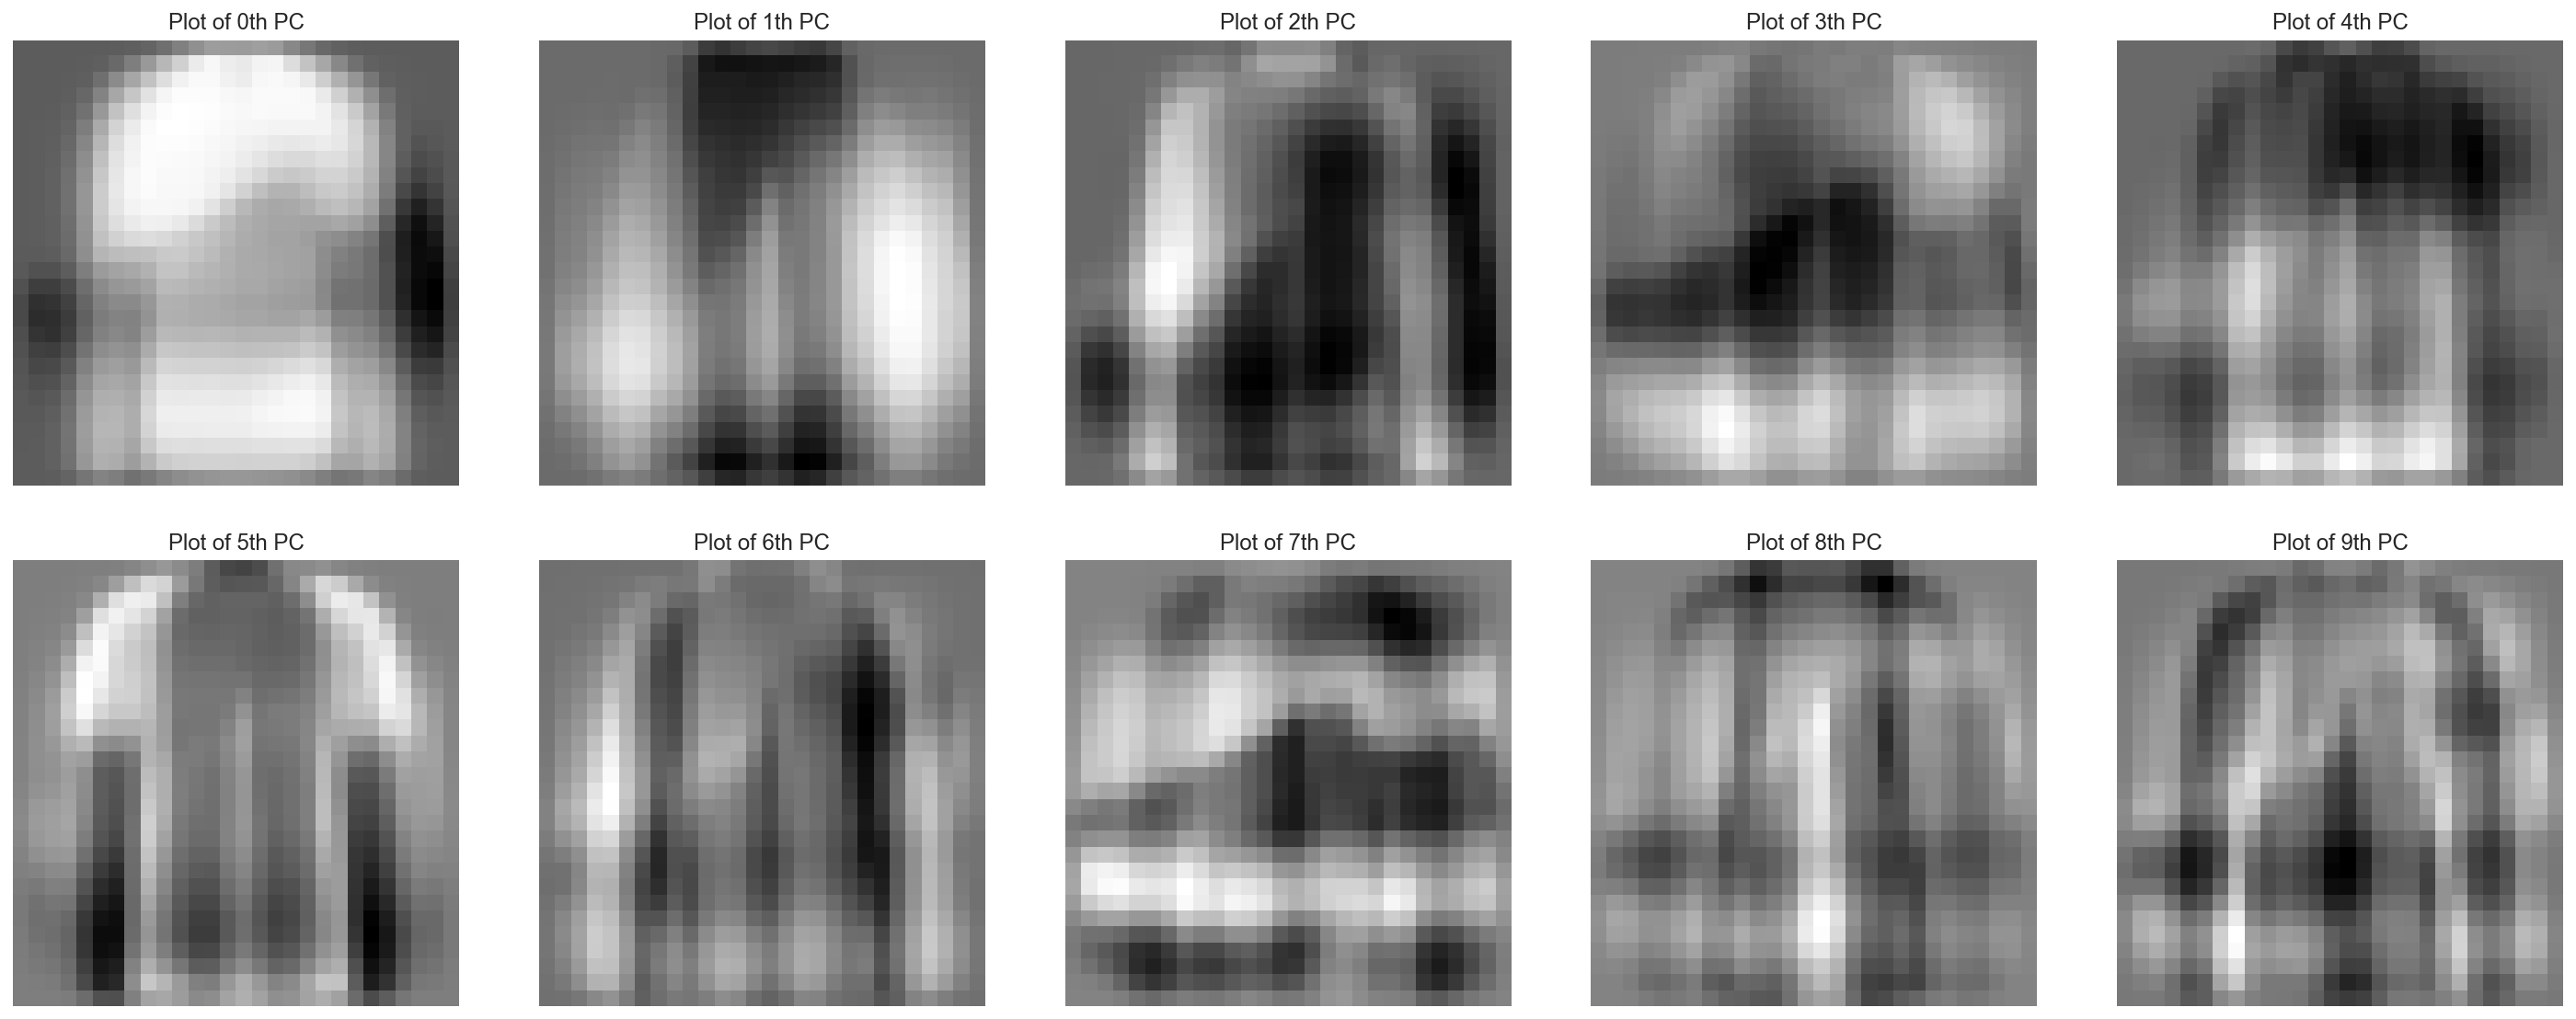

In [104]:
components = pca.components_

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
plt.tight_layout()
for num_pc in range(10):
    pc = components[num_pc, :].reshape(-1, 28)
    ax = axs[num_pc//5, num_pc%5]
    ax.set_title(f"Plot of {num_pc}th PC")
    ax.imshow(pc, cmap='gray')
    ax.axis("off")

# Shortcomings of PCA, and tSNE embedding
In the following section, we will discover sevearl clustering algorithm that overcomes some of the contrains, such as discarding a large proportion of variance of the first two principle components.

tSNE stands for t-distributed stochastic neighbor embedding (tSNE), which is an iterative process of the manifold learning. The processes of tSNE can be summarized by the following steps.

1. A probability distribution over pairs of high dimensional data are constructed such that the data points whose are closer in the higher dimension will have a higher probaility of placing closer in the lower dimensional space
2. Based on the probability distribution created in the first stage, tSNE maps the point into the lower dimension space that minimize the Kullback-Leibler divergence (KL divergence) between the pair's distribution.
3. Repeat to 1 until a specific ending criteria is met.

Since tSNE is an iterative processes, it frequently calculates the distances between points in higher dimension. Therefore, it is wise for us to first reduce the dimensionality of the datapoints, and then do the embeddings.

Text(0.5, 1.0, '83 PCs Captures 90% of the variance')

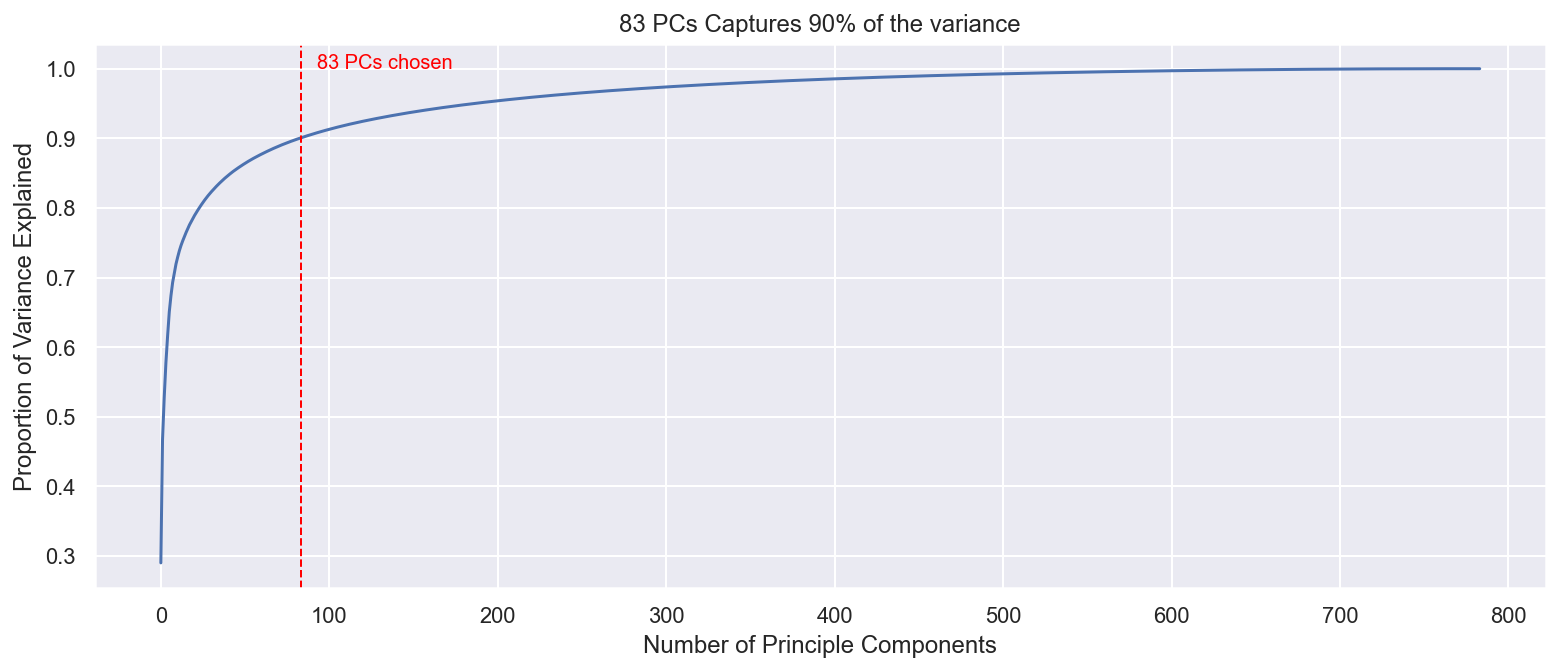

In [119]:
# Plot to see how many PC that we need to used to explain 90% of variance
plt.figure(figsize=(13, 5))
threshold = 0.9
cumsum = np.cumsum(pca.explained_variance_ratio_)
desired_pc = np.argmax(cumsum >= threshold)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Principle Components")
plt.ylabel("Proportion of Variance Explained")
plt.axvline(x=desired_pc, linestyle='dashed', linewidth=1, color='red')
plt.text(s=f"{desired_pc} PCs chosen", x=desired_pc+10, y=1, color='red')
plt.title(f"{desired_pc} PCs Captures 90% of the variance")

In [117]:
from sklearn.manifold import TSNE

def plot_tsne(data, labels, title="2-dim tSNE Embedding", save=False):
    plt.figure(figsize=(10,10))
    two_pcs = transformed[:, :2]
    sns.scatterplot(data[:, 0], data[:, 1], hue=labels, alpha=0.2)
    plt.xlabel("First tSNE")
    plt.ylabel("Second tSNE")
    plt.title(title)
    if save:
        plt.savefig(f"imgs/tSNE.png", dpi=200)

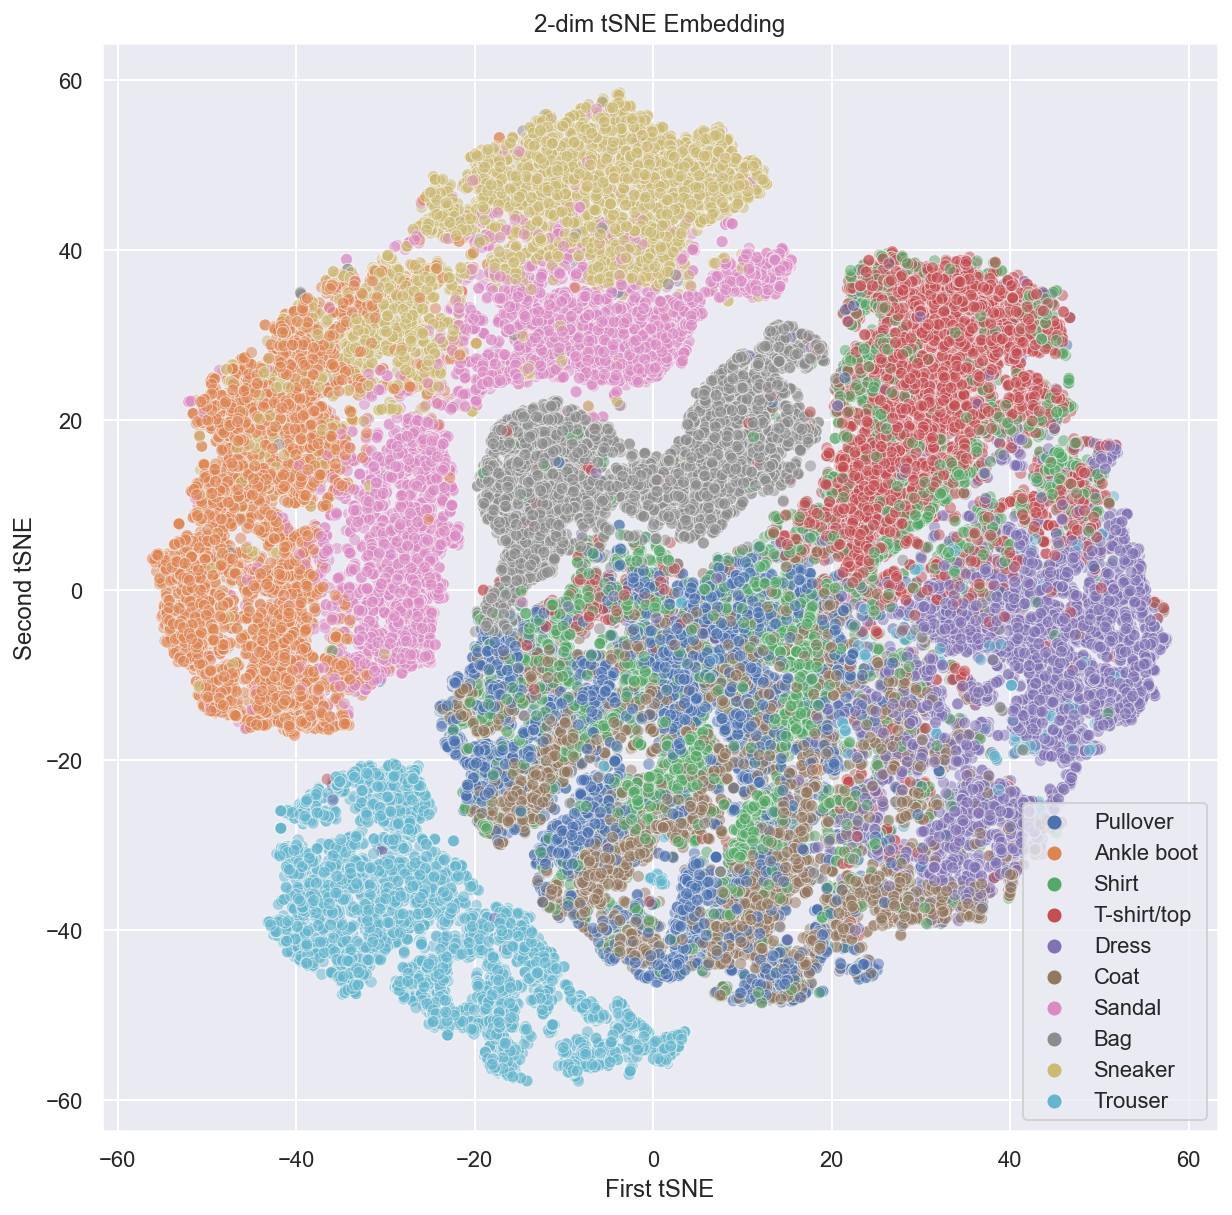

In [107]:
# Perplexity = 30, Default settings
# Since the tSNE is a iterative processes, it will take a relatively
# long computational time
embed = transformed[:, :desired_pc]
tsne = TSNE(n_components=2)
tsne_transformed = tsne.fit_transform(embed)
plot_tsne(tsne_transformed, named_label)

# Comparison Between tSNE and PCA Clustering

PCA Embedding            | tSNE Embedding
:-------------------------:|:-------------------------:
![](imgs/PCA.png)  |  ![](imgs/tSNE.png)

Because of the extra variance that the tSNE is capturing, we can see that the tSNE has a more clear define cluster shape compared with the PCA embeddings.

# Watershed Segmentation, Density Based Clustering

In [121]:
tsne_transformed.shape

(60000, 2)

Text(0.5, 1.0, 'histogram of the Cluster Density')

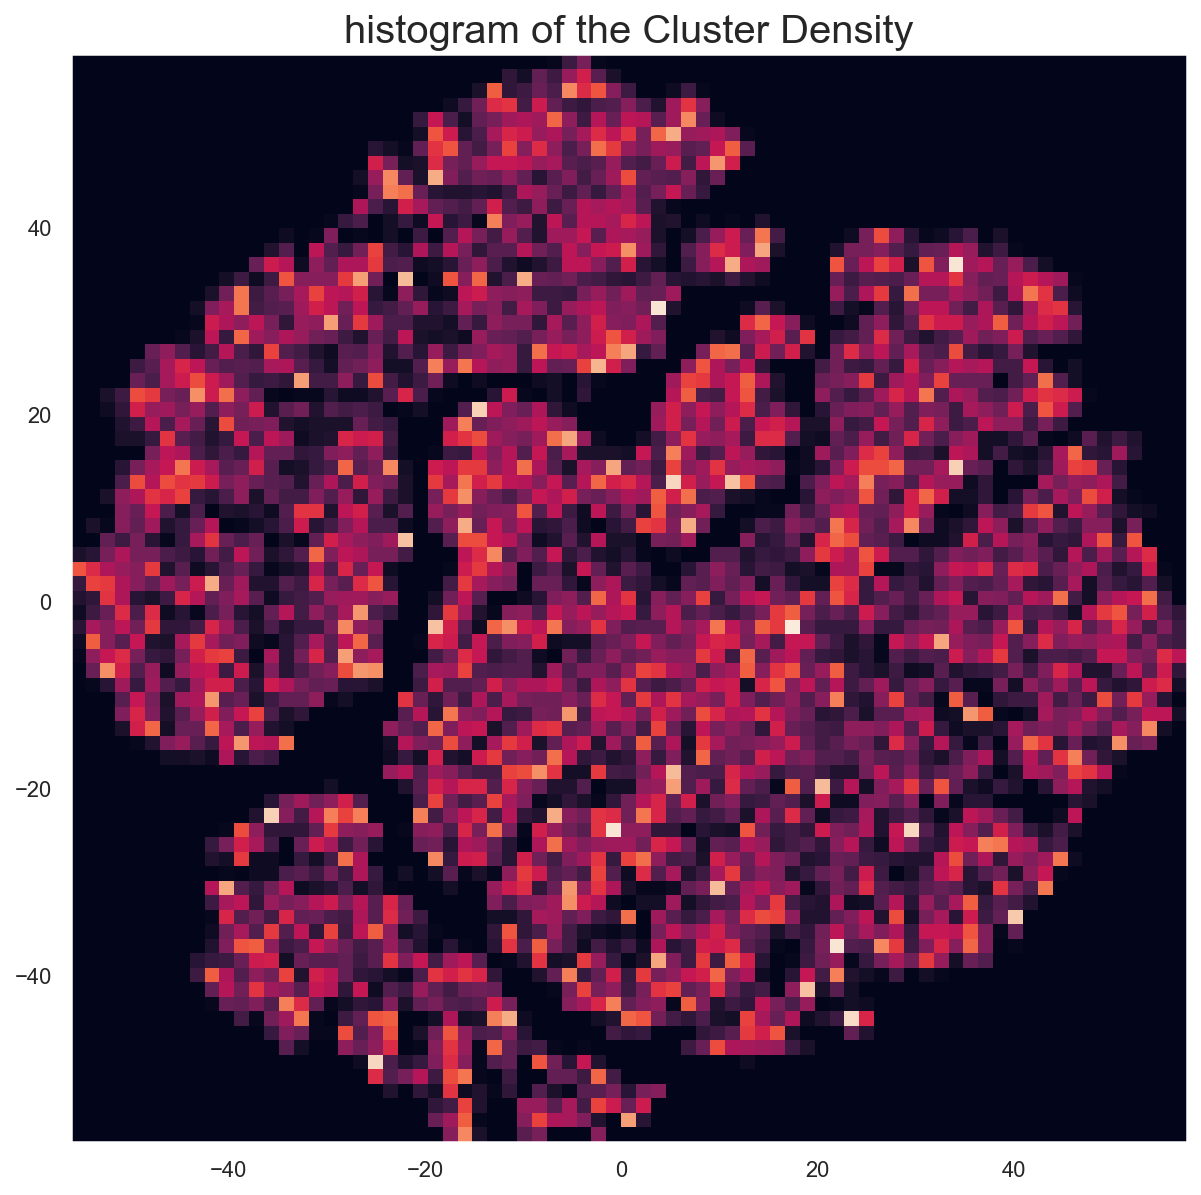

In [135]:
plt.figure(figsize=(10,10))
_ = plt.hist2d(tsne_transformed[:, 0], tsne_transformed[:, 1], bins=75)
plt.title("histogram of the Cluster Density", size=20)

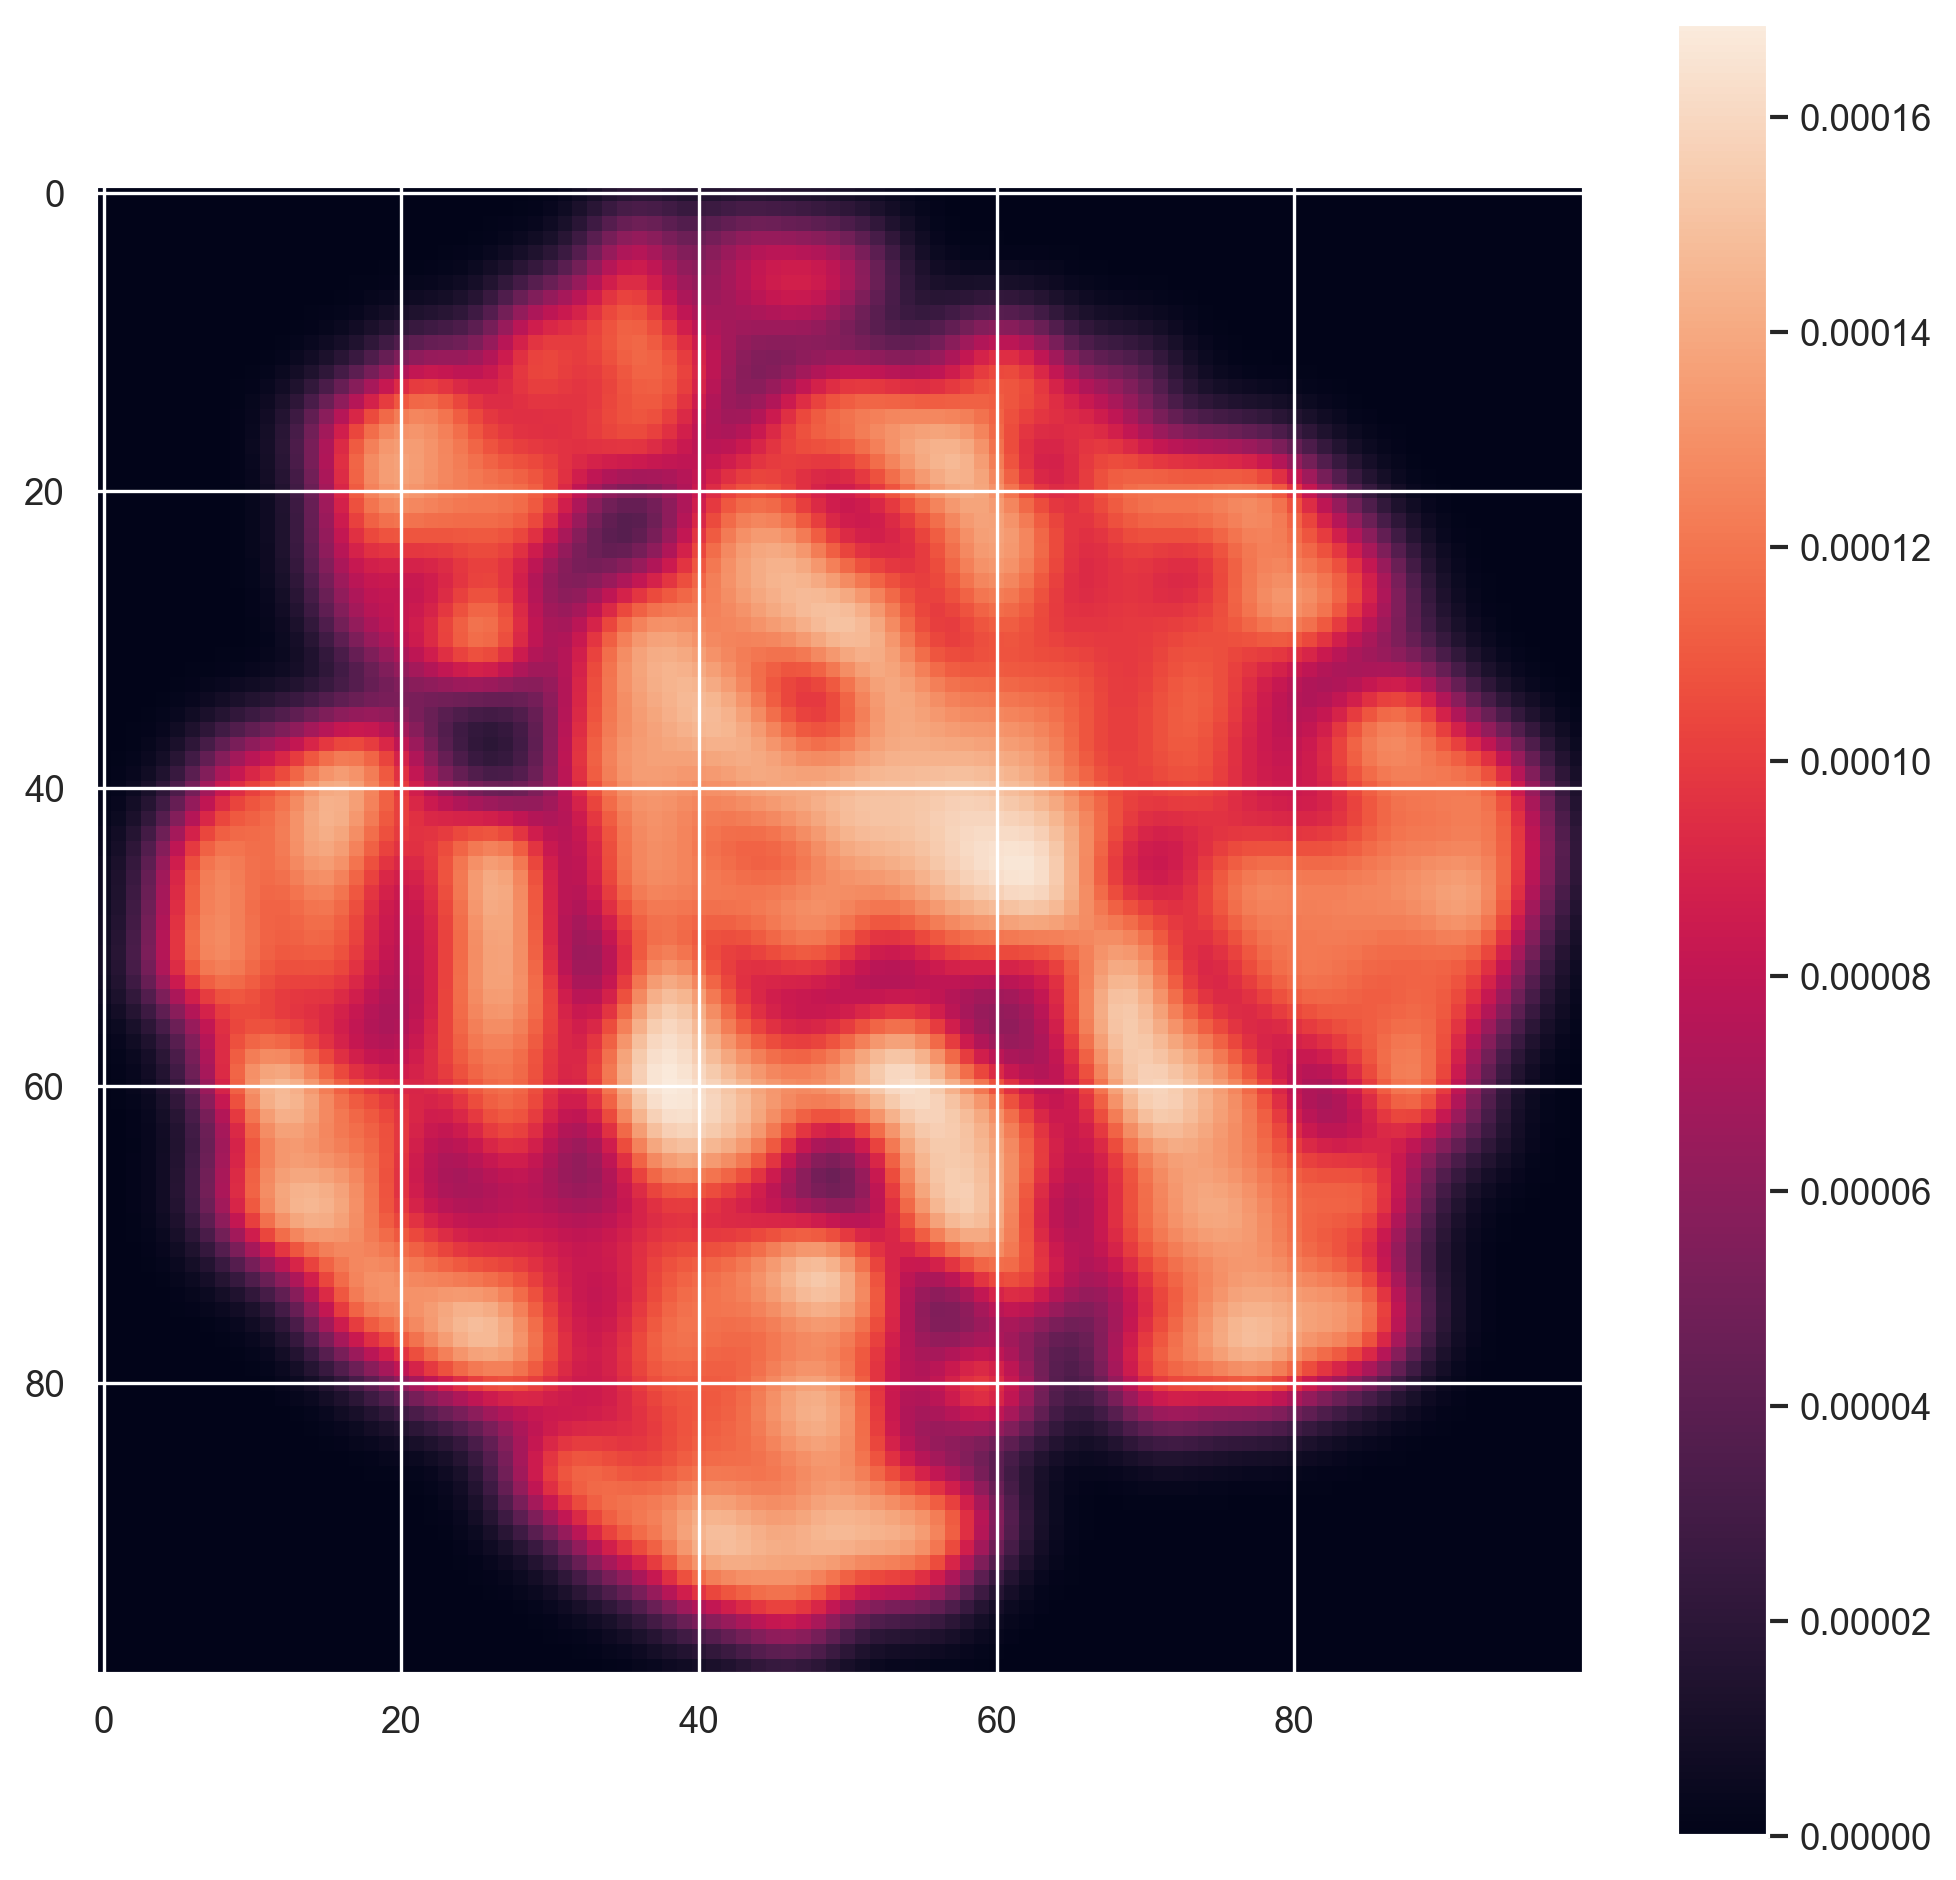

In [155]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(bandwidth=3, kernel="gaussian", algorithm="ball_tree")
kde.fit(tsne_transformed)

n = 100

xv, yv = np.linspace(-60, 60, n), np.linspace(-60, 60, n)
XX, YY = np.meshgrid(xv, yv)

Z = np.exp(kde.score_samples(np.stack([XX.reshape(-1), YY.reshape(-1)], axis=1)))

Z = Z.reshape(XX.shape)

plt.figure(figsize=(10, 10), dpi=120)
plt.imshow(Z)
plt.colorbar()

(100, 100)


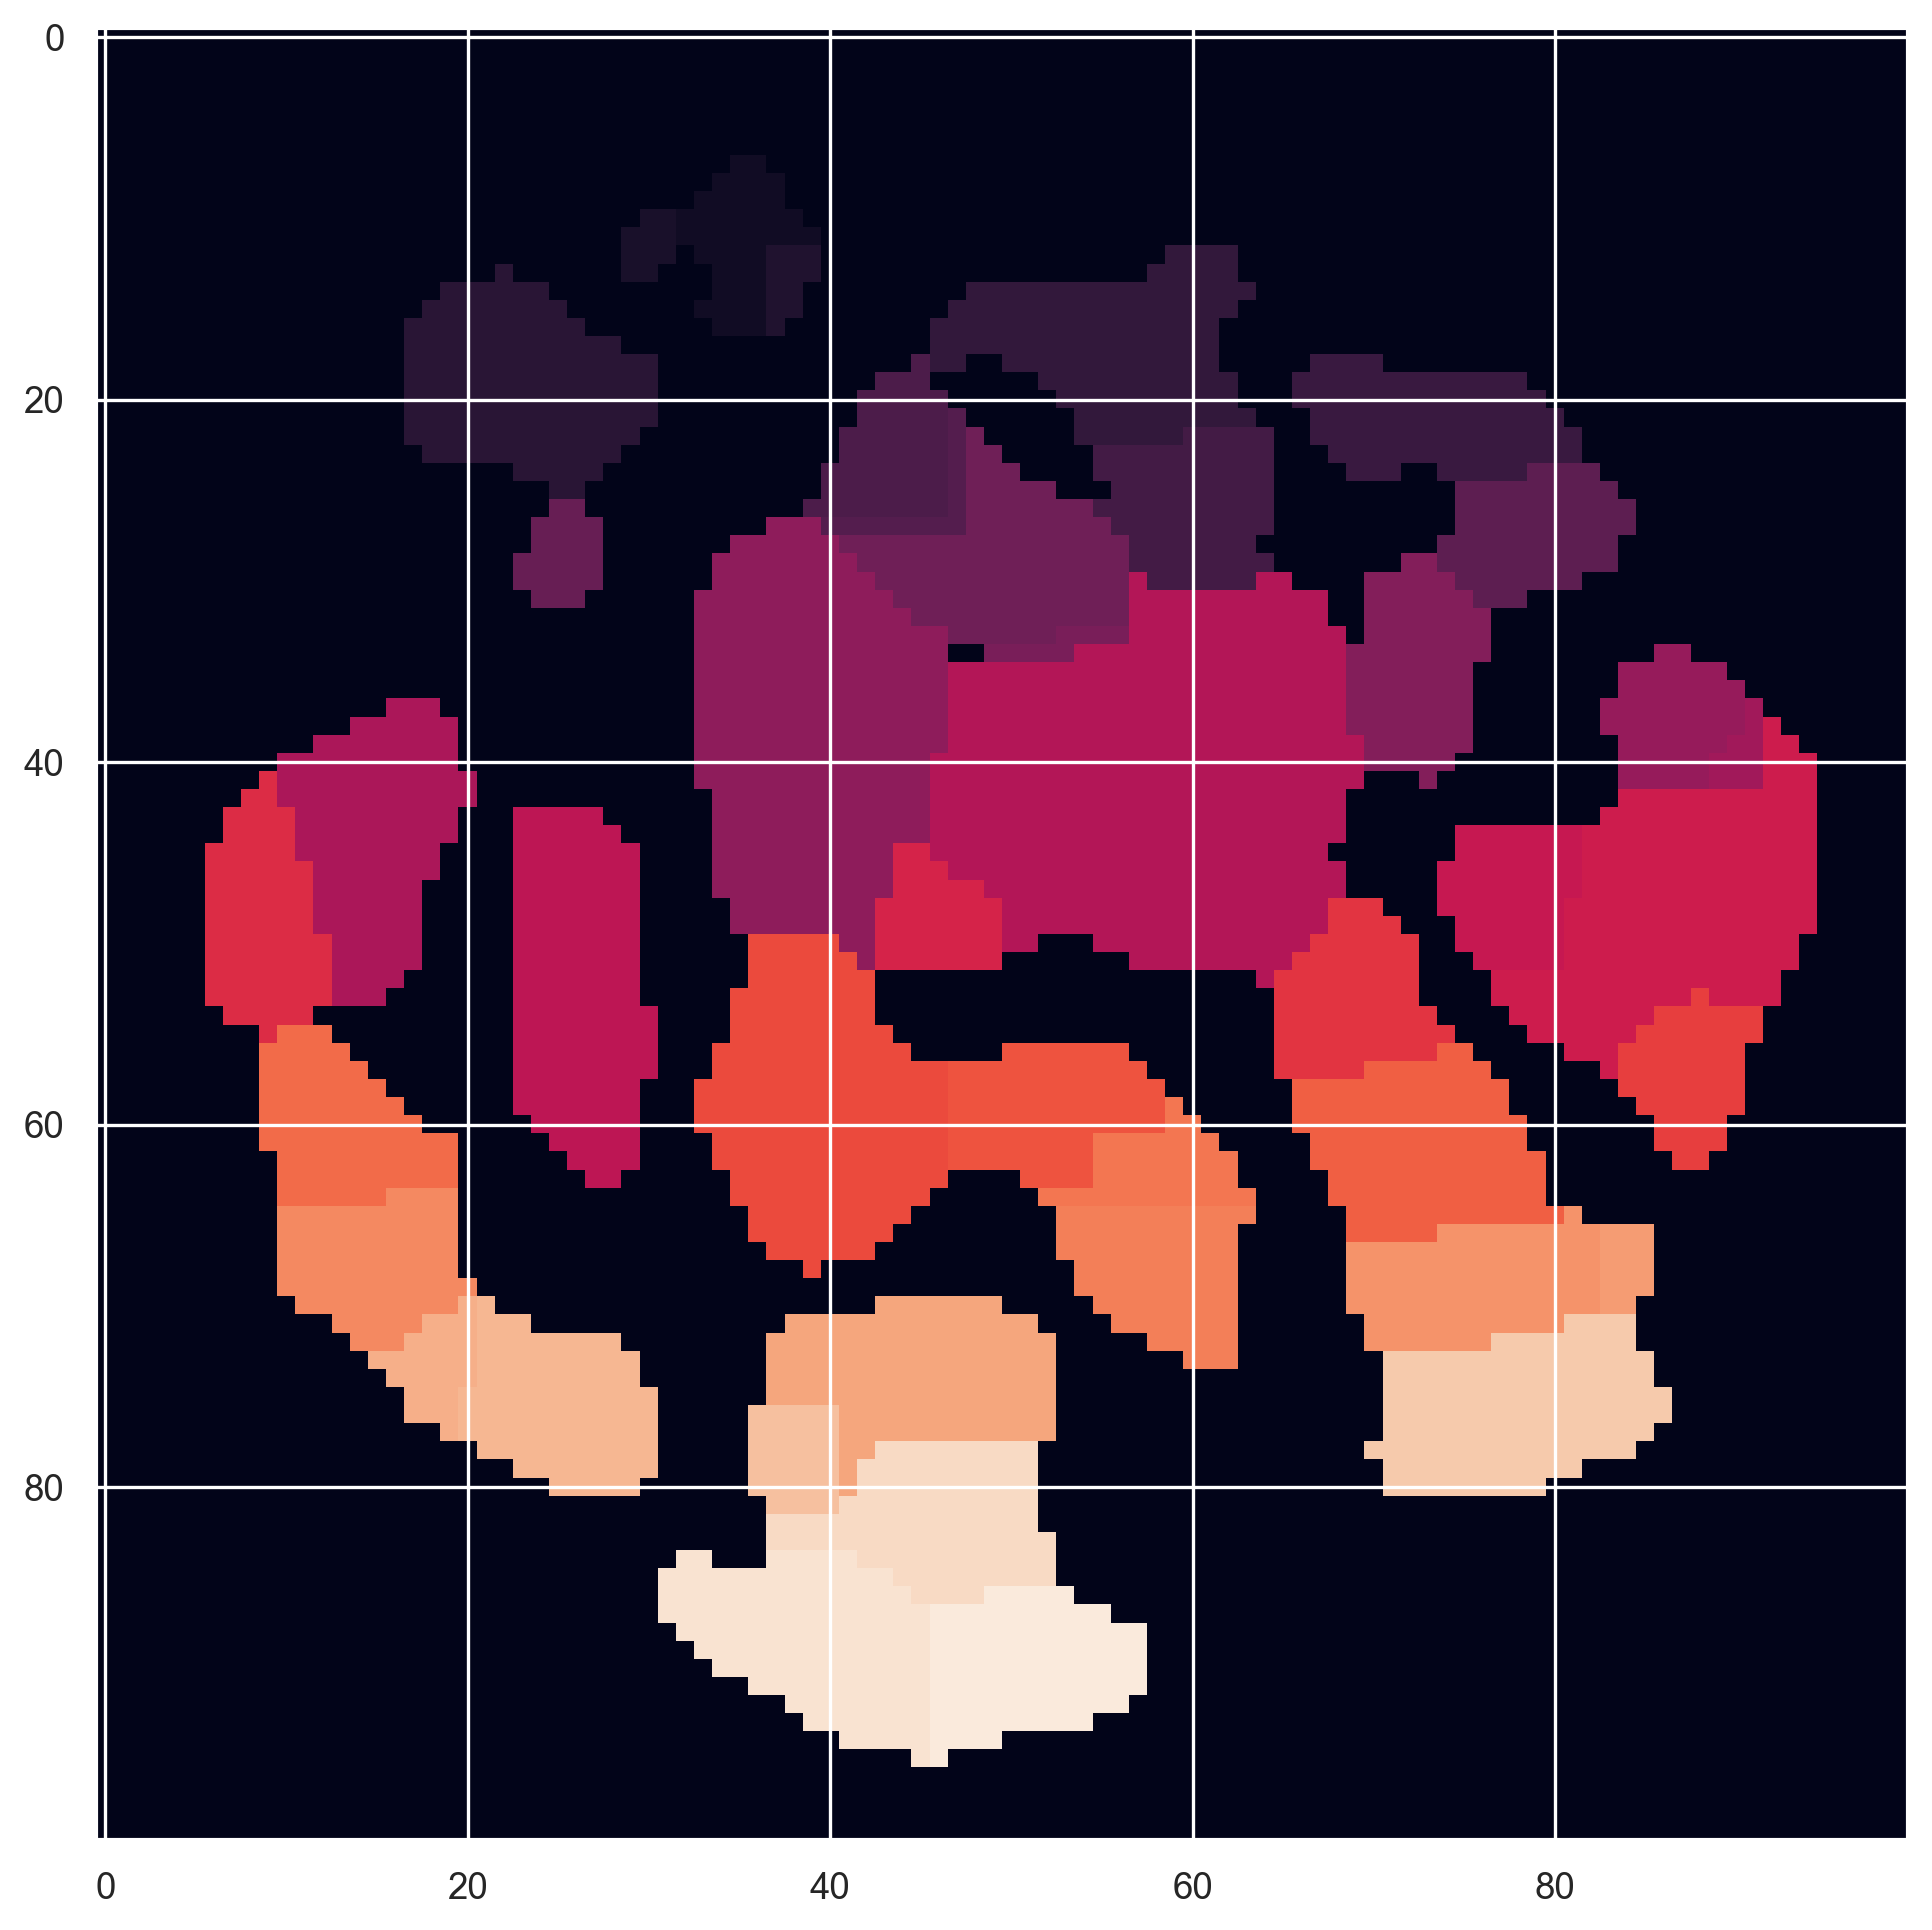

In [161]:
from skimage.segmentation import watershed

L = watershed(-Z)
print(L.shape)

L[Z < 1e-4] = 0

plt.figure(figsize=(10, 10), dpi=120)
plt.imshow(L)

# PCA Continued. See the similar item
From the previous section, we can see that several categories are mingled around together. That's because they are stucturally similar. To increase the classification rate, we can do multiple PCA analysis based on the predicted values. This is a multiple level model prediction.

In [77]:
names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [68]:
shoes_idx = [5, 7, 9]

In [78]:
shoes_img = np.vstack([img_by_category[i] for i in shoes_idx])
shoes_label = np.hstack([np.repeat(names[i], 1000) for i in shoes_idx])

(-0.5, 27.5, 27.5, -0.5)

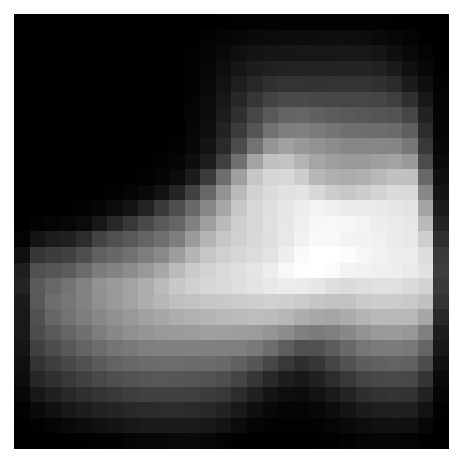

In [70]:
mean_shoes = np.mean(shoes_img, axis=0).reshape(-1, 28)
plt.imshow(mean_shoes, cmap="gray")
plt.axis("off")

In [73]:
shoe_trans[:, :2]

array([[ -153.59009556,  1684.15773098],
       [ -395.17532413,  1259.03583194],
       [-1001.12870834,  -221.01526015],
       ...,
       [  223.04942211,   141.00743753],
       [  888.04868588,   551.67920032],
       [  922.57850754,  -719.01776656]])

Text(0.5, 1.0, '2-dim PCA Embedding')

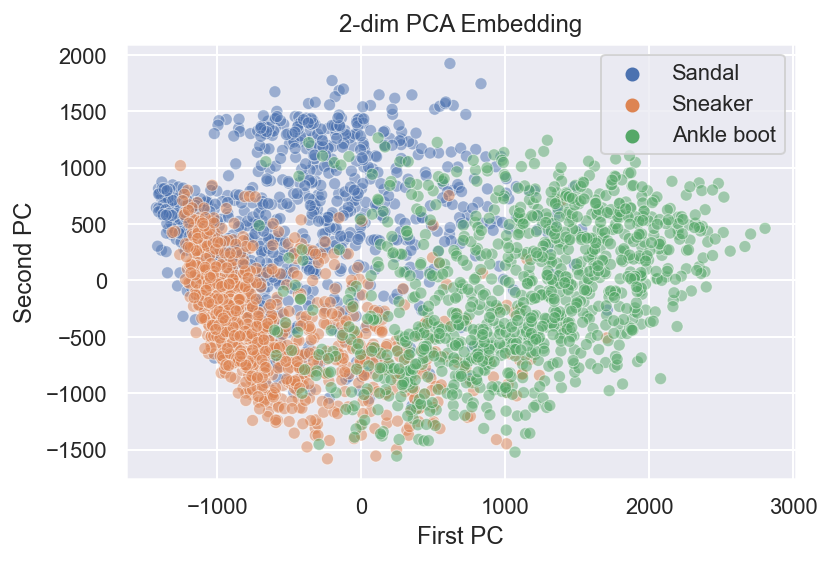

In [79]:
pca = PCA()
shoe_trans = pca.fit_transform(shoes_img)

two_pcs = shoe_trans[:, :2]

sns.scatterplot(two_pcs[:, 0], two_pcs[:, 1], hue=shoes_label, alpha=0.5)
plt.xlabel("First PC")
plt.ylabel("Second PC")
plt.title("2-dim PCA Embedding")

(-0.5, 27.5, 27.5, -0.5)

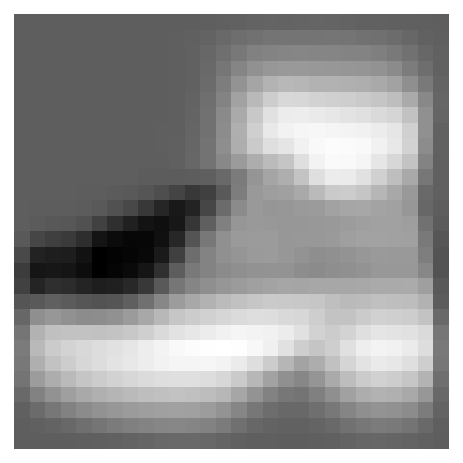

In [92]:
pcs = pca.components_

plt.imshow(pcs[0].reshape(-1, 28), cmap="gray")
plt.axis("off")

# If I have more time...